In [4]:
import os
import numpy as np
import pandas as pd
import itertools
import geopandas as gpd
import rasterio
import fiona
import sklearn.model_selection as model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torcheval.metrics as metrics

import matplotlib.pyplot as plt

In [5]:
import bird_data as data

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
junco_data = data.junco_data.drop(columns = 'observation_date').dropna()
junco_data = junco_data.astype('float32')

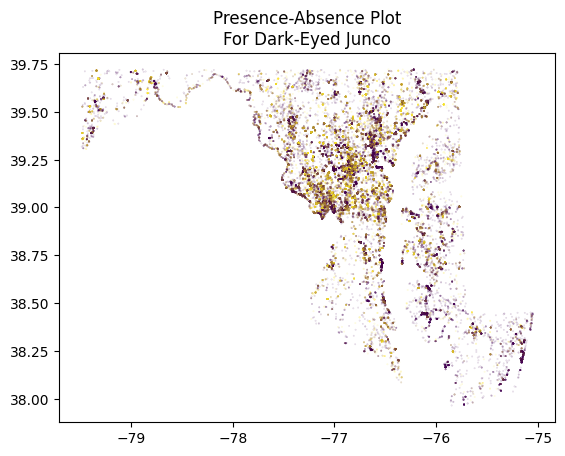

In [8]:
plt.scatter(x = junco_data['longitude'], y = junco_data['latitude'], alpha = 0.2, s = 0.1, c = junco_data['species_observed'])
plt.title('Presence-Absence Plot\nFor Dark-Eyed Junco')
plt.show()

In [9]:
class birdDNN(nn.Module):
    def __init__(self, num_layers, dropout_rate, 
                 input_dim, hidden_dim, output_dim):
        super(birdDNN, self).__init__()
        self.activation = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate else nn.Identity()
        ## Dense Layers
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.LeakyReLU(0.01))
            self.layers.append(nn.Dropout(dropout_rate) if dropout_rate else nn.Identity())
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.activation(self.input_fc(x))
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x)
        x = self.output_fc(x)
        return x

In [ ]:
def birdDNN_train(trainloader, testloader, score, num_epochs, input_dim, output_dim=1, 
                  num_layers=4, dropout_rate=0.2, hidden_dim=64, lr=0.01):
    
    num_classes = 2

    model = birdDNN(input_dim = input_dim, output_dim = output_dim, 
                num_layers = num_layers, dropout_rate = dropout_rate, hidden_dim = hidden_dim).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    accuracy = metrics.MulticlassAccuracy(num_classes = num_classes).to(device)
    auroc = metrics.MulticlassAUROC(num_classes = num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma  = 0.75)

    print("Starting Model Training")
    model.train()
    train_loss = []
    train_accuracy = []
    train_auroc = []
    test_accuracy = []
    test_auroc = []
    predictions = []
    for epoch in range(num_epochs):
        ## Model Training
        running_loss = 0
        for inputs, presence in trainloader:
            optimizer.zero_grad()
            inputs, presence = inputs.to(device), presence.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, presence)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy.update(F.softmax(outputs, dim = 1), presence).to(device)
            auroc.update(F.softmax(outputs, dim = 1), presence).to(device)
        train_accuracy.append(accuracy.compute().cpu().numpy())
        train_auroc.append(auroc.compute().cpu().numpy())
        train_loss.append(running_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch + 1}\n')
            print(f'Loss: {train_loss[epoch]}\n')
            print(f'Accuracy: {train_accuracy[epoch]}\n')
            print(f'AUROC: {train_auroc[epoch]}\n')

        # Model Validation
        accuracy.reset()
        auroc.reset()

        model.eval()
        with torch.no_grad():
            for inputs, presence in testloader:
                inputs, presence = inputs.to(device), presence.to(device)
                outputs = model(inputs)
                accuracy.update(F.softmax(outputs, dim = 1), presence).to(device)
                auroc.update(F.softmax(outputs, dim = 1), presence).to(device)
                predictions.append(outputs.cpu())
        test_accuracy.append(accuracy.compute().cpu().numpy())
        test_auroc.append(auroc.compute().cpu().numpy())
        if (epoch + 1) % 10 == 0:
            print(f'Test Accuracy: {test_accuracy[epoch]}\n')
            print(f'Test AUROC: {test_auroc[epoch]}\n')
        
        score.append(test_accuracy[-1])
        accuracy.reset()
        auroc.reset()
        model.train()
    
    return model.state_dict(), score, predictions


In [11]:
parameter_grid = data.parameter_grid
folds = 3
num_epochs = 20
results = {}
kfold = model_selection.KFold(n_splits = folds, shuffle = True, random_state = 6260)
for params in itertools.product(*parameter_grid.values()):
    num_layers, dropout_rate, hidden_dim = params
    scores = []
    os.makedirs(f'./model_states/model_{params}', exist_ok=True)
    for folds, (train_idx, test_idx) in enumerate(kfold.split(junco_data)):
        train_percent = 0.8
        junco_features = junco_data.drop(columns = 'species_observed')
        junco_labels = junco_data['species_observed']

        # x_train, x_test, y_train, y_test  = model_selection.train_test_split(junco_features, junco_labels, train_size = train_percent,
        #                                                             shuffle = True,
        #                                                             random_state = 6260)

        x_train = junco_features.iloc[train_idx]
        y_train = junco_labels.iloc[train_idx]

        x_test = junco_features.iloc[test_idx]
        y_test = junco_labels.iloc[test_idx]

        trainset = TensorDataset(torch.tensor(x_train.to_numpy()), torch.tensor(y_train.to_numpy(), dtype = torch.long))
        testset = TensorDataset(torch.tensor(x_test.to_numpy()), torch.tensor(y_test.to_numpy(), dtype = torch.long))
        trainloader = DataLoader(trainset, batch_size = 32, shuffle = True)
        testloader = DataLoader(testset, batch_size = 32)

        model_state, model_score = birdDNN_train(trainloader, testloader, score = scores,
                      num_epochs = 20, input_dim = junco_features.shape[1], output_dim = 2, 
                      num_layers = num_layers, dropout_rate = dropout_rate, hidden_dim = hidden_dim, lr = 0.005)
        
        
        torch.save(model_state, f'./model_states/model_{params}/model_state_{folds}.pt')
    avg_score = np.mean(scores)
    results[params] = avg_score

Starting Model Training


KeyboardInterrupt: 

In [12]:
train_percent = 0.8
junco_features = junco_data.drop(columns = 'species_observed')
junco_labels = junco_data['species_observed']
x_train, x_test, y_train, y_test  = model_selection.train_test_split(junco_features, junco_labels, train_size = train_percent,
                                                            shuffle = True,
                                                            random_state = 6260)
# x_train = junco_features.iloc[train_idx]
# y_train = junco_labels.iloc[train_idx]
# x_test = junco_features.iloc[test_idx]
# y_test = junco_labels.iloc[test_idx]
trainset = TensorDataset(torch.tensor(x_train.to_numpy()), torch.tensor(y_train.to_numpy(), dtype = torch.long))
testset = TensorDataset(torch.tensor(x_test.to_numpy()), torch.tensor(y_test.to_numpy(), dtype = torch.long))
trainloader = DataLoader(trainset, batch_size = 32, shuffle = True)
testloader = DataLoader(testset, batch_size = 32)

model_state, score, pred = birdDNN_train(trainloader, testloader, score = [], num_epochs = 25, input_dim = junco_features.shape[1], output_dim = 2)

Starting Model Training
Epoch: 10

Loss: 1664.344287008047

Accuracy: 0.5508742332458496

AUROC: 0.5074493885040283

Test Accuracy: 0.6000121235847473

Test AUROC: 0.6604494452476501

Epoch: 20

Loss: 208703.4144756794

Accuracy: 0.530931293964386

AUROC: 0.49702316522598267

Test Accuracy: 0.6000121235847473

Test AUROC: 0.45898836851119995



In [23]:
print(score)

[array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.60007286, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.6000121, dtype=float32), array(0.5796151, dtype=float32), array(0.5993444, dtype=float32), array(0.6000121, dtype=float32), array(0.5997693, dtype=float32)]
